In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Deep Learning Model Pytorch

In [ ]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import models

In [ ]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train = ImageFolder('/content/drive/My Drive/DataSets/3-classes/Train', transform=transform)
valid = ImageFolder('/content/drive/My Drive/DataSets/3-classes/Val', transform=transform)

In [ ]:
classes = train.classes
classes

['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
img, label = train[123]
print(img)
#print(label)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


In [ ]:
img, label = train[123]
print(img, label)
print(img.shape)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]) 0
torch.Size([3, 180, 180])


In [ ]:
batch_size = 32

num_workers = 4

train_loader = DataLoader(train, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True, pin_memory=True)

In [ ]:
def imshow(img):  # unnormalize
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

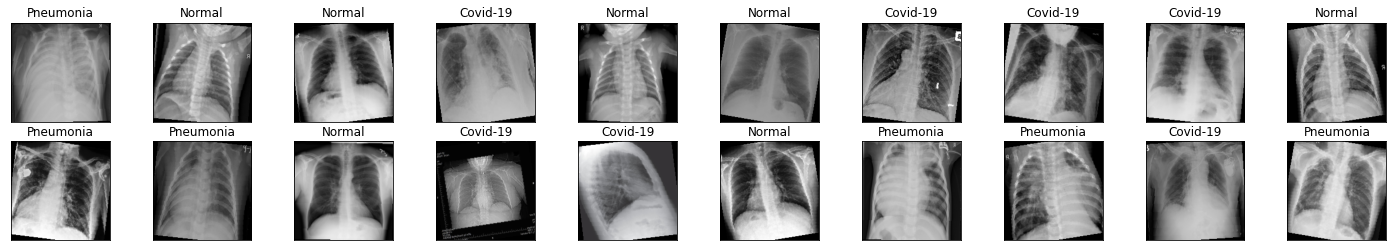

In [ ]:
# Visualizing Data

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    valid_loss_min = np.Inf
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        if result["val_loss"] < valid_loss_min:
             print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
             valid_loss_min,
             result["val_loss"]))
             torch.save(model.state_dict(), "/content/drive/My Drive/DataSets/3-classes/covid_model.pt")
             valid_loss_min = result["val_loss"]
        history.append(result)
    return history

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            #16 x 180 x 180
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 90 x 90
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            #32 x 90 x 90
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 45 x 45

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #64 x 45 x 45
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 22 x 22

            nn.Dropout(0.2),

            nn.Flatten(),

            nn.Linear(64*22*22, 128),

            nn.ReLU(),

            nn.Linear(128, 3))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=30976, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
to_device(model, device);

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
evaluate(model, valid_loader)

{'val_acc': 0.328125, 'val_loss': 1.0991508960723877}

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

Epoch [0], train_loss: 0.8562, val_loss: 0.9991, val_acc: 0.4802
Validation loss decreased (inf --> 0.999139).  Saving model ...
Epoch [1], train_loss: 0.5611, val_loss: 0.7994, val_acc: 0.6667
Validation loss decreased (0.999139 --> 0.799364).  Saving model ...
Epoch [2], train_loss: 0.4519, val_loss: 0.7098, val_acc: 0.7250
Validation loss decreased (0.799364 --> 0.709773).  Saving model ...
Epoch [3], train_loss: 0.3969, val_loss: 0.6018, val_acc: 0.7719
Validation loss decreased (0.709773 --> 0.601812).  Saving model ...
Epoch [4], train_loss: 0.3527, val_loss: 0.7005, val_acc: 0.6823
Epoch [5], train_loss: 0.3001, val_loss: 0.6127, val_acc: 0.7469
Epoch [6], train_loss: 0.2863, val_loss: 0.7756, val_acc: 0.6333
Epoch [7], train_loss: 0.2505, val_loss: 0.6368, val_acc: 0.7344
Epoch [8], train_loss: 0.2365, val_loss: 0.4851, val_acc: 0.7844
Validation loss decreased (0.601812 --> 0.485076).  Saving model ...
Epoch [9], train_loss: 0.2259, val_loss: 0.8224, val_acc: 0.6333
Epoch [10]